In [ ]:
!pip install rarfile
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
import rarfile
import os

# Define the path to the .rar file
rar_file_path = '/content/Brain_tumor.rar'

# Create a directory to extract the files
extract_dir = '/content/Brain_tumor'
os.makedirs(extract_dir, exist_ok=True)

# Decompress the .rar file
with rarfile.RarFile(rar_file_path) as rf:
    rf.extractall(extract_dir)

# Verify the extraction
print(f"Files unzipped to {extract_dir}")
!ls {extract_dir}


Files unzipped to /content/Brain_tumor
Brain_tumor


In [ ]:
! pip install torchinfo
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

! pip install torchinfo
import ipywidgets as widgets
import io
from PIL import Image
import tqdm
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import requests
import zipfile
from pathlib import Path

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [ ]:
random.seed(42)

training_data_path = Path("/content/Brain_tumor/Brain_tumor/Training")

image_path_list = list(training_data_path.glob("*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)


print(f"Random image path: {random_image_path}")
print(f"image class: {image_class}")
print(f"image height: {img.height}")
print(f"image width: {img.width}")

Random image path: /content/Brain_tumor/Brain_tumor/Training/pituitary_tumor/p (254).jpg
image class: pituitary_tumor
image height: 512
image width: 512


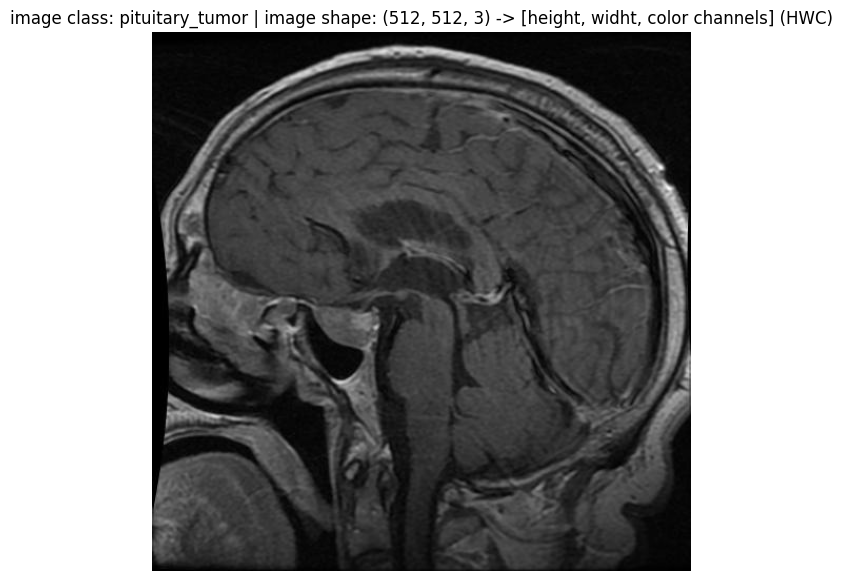

In [ ]:
img_as_array = np.asarray(img)

plt.figure(figsize = (10,7))
plt.imshow(img_as_array)
plt.title(f"image class: {image_class} | image shape: {img_as_array.shape} -> [height, widht, color channels] (HWC)")
plt.axis(False);

## Data Transformation

In [ ]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(           #This normalization is applied as it is the same applied to the images in ImageNet
            mean=[0.485, 0.456, 0.406], #and we'll be using Trasnfer Learning (for example EfficientNetB0)
            std=[0.229, 0.224, 0.225])
    ])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load datasets
train_data = datasets.ImageFolder(root='/content/Brain_tumor/Brain_tumor/Training',
                                  transform = train_transform,
                                  target_transform = None)

test_data = datasets.ImageFolder(root='/content/Brain_tumor/Brain_tumor/Testing',
                                  transform = test_transform,
                                  target_transform = None)

BATCH_SIZE = 64

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                              batch_size = BATCH_SIZE,
                              num_workers = 1,
                              shuffle = False)

In [ ]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7a31da26d360>, <torch.utils.data.dataloader.DataLoader object at 0x7a32c03a2470>)
Length of train dataloader: 45 batches of 64
Length of test dataloader: 7 batches of 64


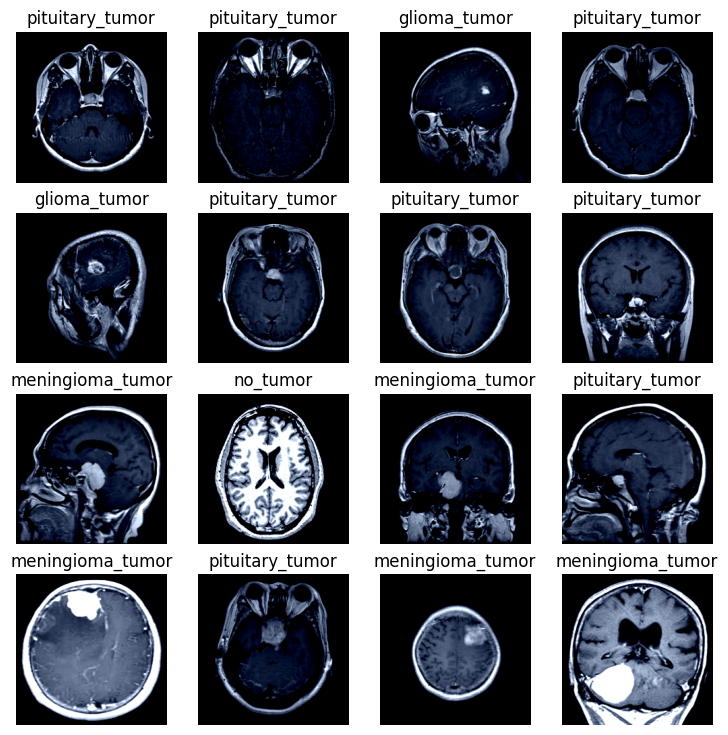

In [ ]:
# Plot more images
torch.manual_seed(42)

class_names = train_data.classes
class_to_idx = train_data.class_to_idx

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0).numpy() * 0.5 + 0.5  # unnormalize and convert to numpy array
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.show()

In [ ]:
## Check out whats inside the training dataloader

train_features_batch, train_labels_batch = next(iter(train_dataloader))

train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

## Train, Test, Pipeline, and Plotting functions

In [ ]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device = device):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()
        #  computes the gradients of the loss with respect to the model's parameters by backpropagating the error

        # 5. Optimizer step
        optimizer.step()
        # updates the model's parameters using the gradients to minimize the loss. The optimization algorithm determines how much to adjust each parameter.

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def pipeline(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          scheduler=None,
          epochs: int = 5,
          device=device):


    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }


    for epoch in tqdm(range(epochs)):
      train_loss, train_acc = train_step(model = model,
                                        dataloader = train_dataloader,
                                        loss_fn = loss_fn,
                                        optimizer = optimizer,
                                          device=device)

      test_loss, test_acc = test_step(model = model,
                                      dataloader = test_dataloader,
                                      loss_fn = loss_fn,
                                      device=device
                                        )

      print(f"epoch: {epoch} | train loss: {train_loss: .4f} | train acc: {train_acc: .4f} | test loss: {test_loss: .4f} | test acc: {test_acc: .4f}")

      results["train_loss"].append(train_loss)
      results["train_acc"].append(train_acc)
      results["test_loss"].append(test_loss)
      results["test_acc"].append(test_acc)

      if scheduler:
            scheduler.step(test_loss)


    return results

In [ ]:
def plot_results(results):
    epochs = range(1, len(results['train_loss']) + 1)

    plt.figure(figsize=(12, 8))

    # Plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(epochs, results['train_loss'], label='Training Loss')
    plt.plot(epochs, results['test_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(epochs, results['train_acc'], label='Training Accuracy')
    plt.plot(epochs, results['test_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


## Base Model

In [ ]:
class CNN(nn.Module):

  def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding =0),

        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding =0),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),

        nn.ReLU(),

        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 0),

        nn.ReLU(),

        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units * 53 * 53,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(x.shape)
    x = self.conv_block_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x

In [ ]:
torch.cuda.manual_seed(42)

model_0 = CNN(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)


NUM_EPOCHS = 5



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(),
                             lr = 0.001)


from timeit import default_timer as timer
start_time = timer()

model_0_results = pipeline(model = model_0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        scheduler = None,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = timer()

print(f"total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0 | train loss:  0.9300 | train acc:  0.5875 | test loss:  2.8015 | test acc:  0.4501
epoch: 1 | train loss:  0.5833 | train acc:  0.7598 | test loss:  2.5509 | test acc:  0.5506
epoch: 2 | train loss:  0.4053 | train acc:  0.8463 | test loss:  2.7097 | test acc:  0.5801
epoch: 3 | train loss:  0.2956 | train acc:  0.8920 | test loss:  3.6683 | test acc:  0.6605
epoch: 4 | train loss:  0.1746 | train acc:  0.9400 | test loss:  4.1075 | test acc:  0.7118
total training time:  98.180 seconds


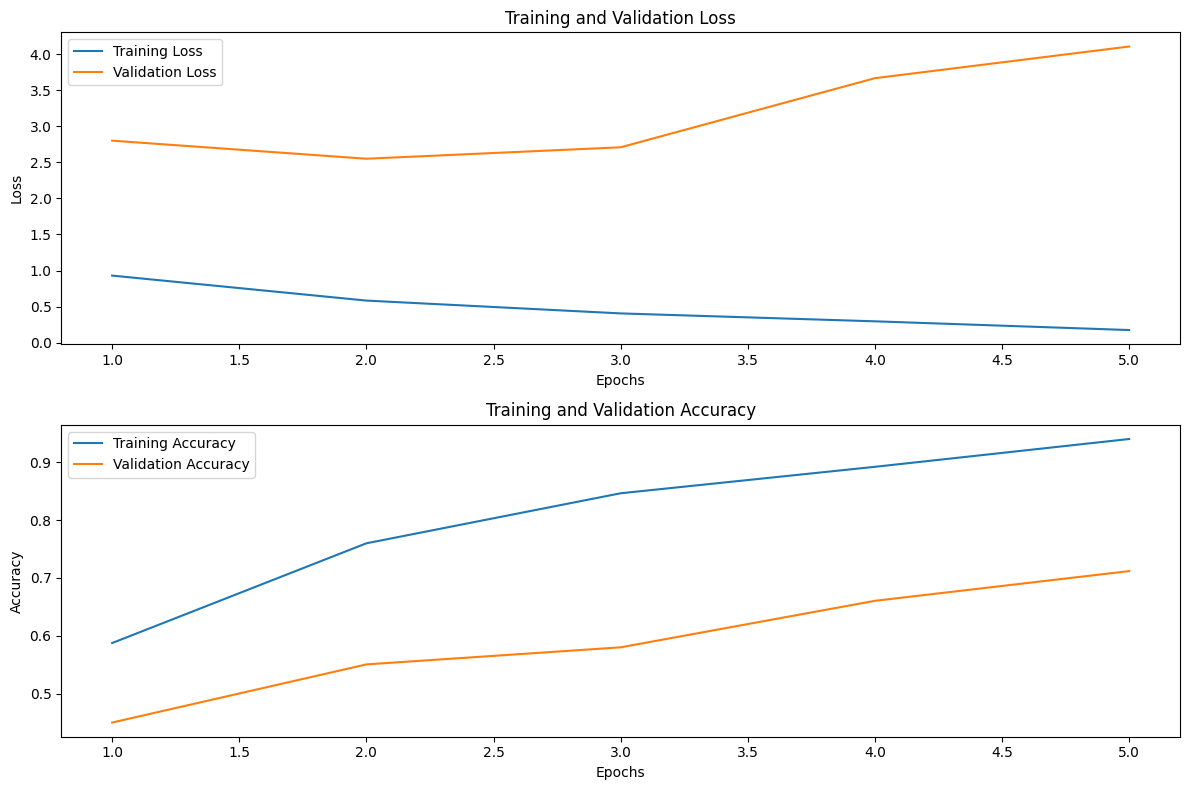

In [ ]:
plot_results(model_0_results)

In [ ]:
torch.cuda.manual_seed(42)

torch.manual_seed(42)

model_1 = CNN(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)


NUM_EPOCHS = 10



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_1.parameters(),
                             lr = 0.001)


from timeit import default_timer as timer
start_time = timer()

model_1_results = pipeline(model = model_1,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        scheduler = None,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = timer()

print(f"total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 | train loss:  1.2259 | train acc:  0.4566 | test loss:  2.1503 | test acc:  0.4122
epoch: 1 | train loss:  0.7116 | train acc:  0.7160 | test loss:  3.4385 | test acc:  0.4973
epoch: 2 | train loss:  0.5002 | train acc:  0.8114 | test loss:  3.0782 | test acc:  0.6362
epoch: 3 | train loss:  0.3859 | train acc:  0.8565 | test loss:  3.6577 | test acc:  0.6786
epoch: 4 | train loss:  0.2673 | train acc:  0.9146 | test loss:  4.7601 | test acc:  0.7254
epoch: 5 | train loss:  0.1747 | train acc:  0.9396 | test loss:  5.8018 | test acc:  0.7277
epoch: 6 | train loss:  0.1167 | train acc:  0.9628 | test loss:  6.9904 | test acc:  0.7455
epoch: 7 | train loss:  0.0843 | train acc:  0.9742 | test loss:  9.3891 | test acc:  0.7679
epoch: 8 | train loss:  0.0431 | train acc:  0.9892 | test loss:  9.6499 | test acc:  0.7250
epoch: 9 | train loss:  0.0670 | train acc:  0.9799 | test loss:  5.0017 | test acc:  0.7656
total training time:  177.104 seconds


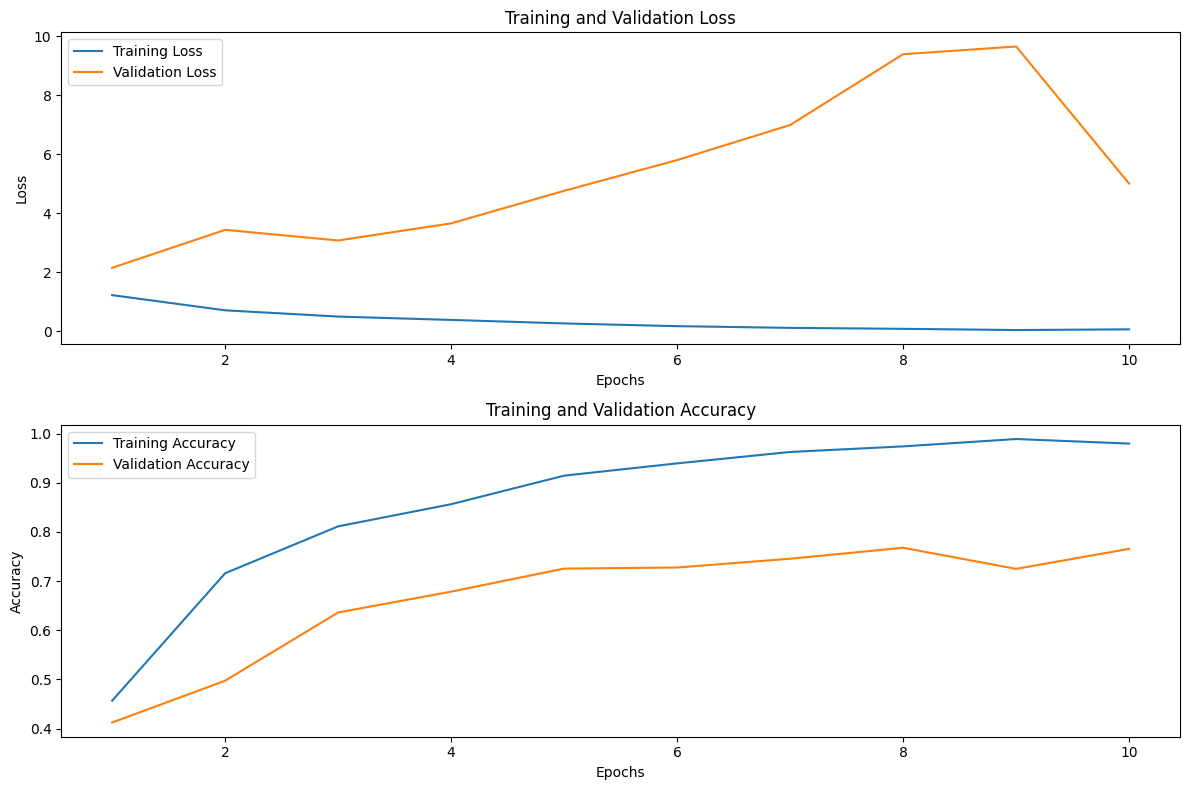

In [ ]:
plot_results(model_1_results)

In [ ]:
torch.cuda.manual_seed(42)

torch.manual_seed(42)

model_2 = CNN(input_shape = 3,
                  hidden_units = 10,
                  output_shape = len(class_names)).to(device)


NUM_EPOCHS = 10



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_2.parameters(),
                             lr = 0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

from timeit import default_timer as timer
start_time = timer()

model_2_results = pipeline(model = model_2,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        scheduler = scheduler,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = timer()

print(f"total training time: {end_time-start_time: .3f} seconds")

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 | train loss:  1.2261 | train acc:  0.4569 | test loss:  2.1537 | test acc:  0.4122
epoch: 1 | train loss:  0.7126 | train acc:  0.7156 | test loss:  3.4481 | test acc:  0.4995
epoch: 2 | train loss:  0.5018 | train acc:  0.8131 | test loss:  3.0780 | test acc:  0.6339
epoch: 3 | train loss:  0.3869 | train acc:  0.8552 | test loss:  3.7464 | test acc:  0.6786
epoch: 4 | train loss:  0.2785 | train acc:  0.9066 | test loss:  4.6798 | test acc:  0.7254
epoch: 5 | train loss:  0.1927 | train acc:  0.9306 | test loss:  5.2260 | test acc:  0.7118
epoch: 6 | train loss:  0.1520 | train acc:  0.9470 | test loss:  6.3534 | test acc:  0.6825
epoch: 7 | train loss:  0.0903 | train acc:  0.9764 | test loss:  6.3588 | test acc:  0.7093
epoch: 8 | train loss:  0.0662 | train acc:  0.9871 | test loss:  7.2641 | test acc:  0.7183
epoch: 9 | train loss:  0.0559 | train acc:  0.9888 | test loss:  7.8519 | test acc:  0.7160
total training time:  173.477 seconds


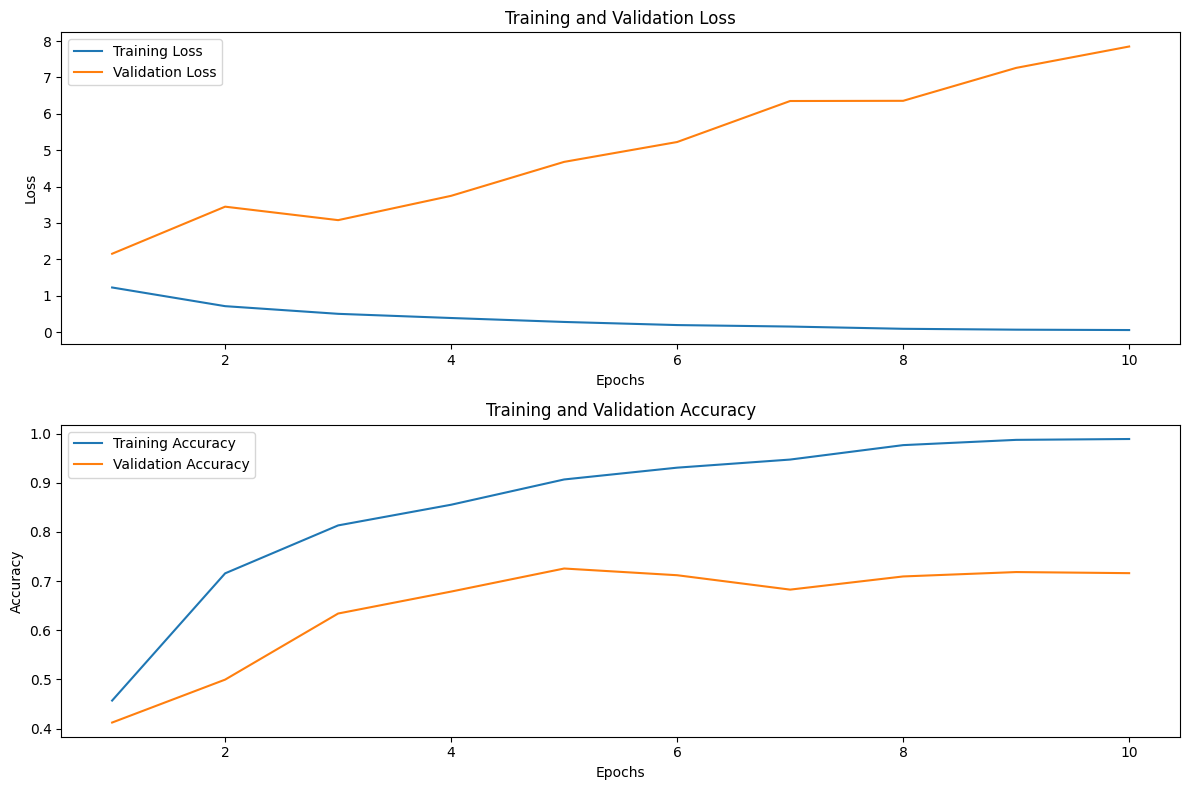

In [ ]:
plot_results(model_2_results)

## Importing the pre-trained model

In [ ]:

from torchinfo import summary
from torchvision import models
from torch import nn
torch.cuda.manual_seed(42)
import torchvision.models


def pre_trained(weights_class,
               model_class,
               drop_out,
               in_features,
               out_features,
               device = device):

    weights = weights_class.DEFAULT

    model = model_class(weights = weights)

    auto_transforms = weights.transforms()

    train_data = datasets.ImageFolder(root='/content/Brain_tumor/Brain_tumor/Training',
                                      transform = auto_transforms ,
                                      target_transform = None)

    # Load datasets
    test_data = datasets.ImageFolder(root='/content/Brain_tumor/Brain_tumor/Testing',
                                      transform = auto_transforms ,
                                      target_transform = None)
    model.classifier = nn.Sequential(
        nn.Dropout(p = drop_out, inplace = True), # prevents overfitting by randomly zeroing out neurons in this case 20 % |
        nn.Linear(in_features = in_features,
                  out_features = out_features)).to(device)

    model = model.to(device)

    return model

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

model_3_EF_B0 = pre_trained(EfficientNet_B0_Weights, efficientnet_b0, drop_out = 0.5, in_features = 1280, out_features = len(class_names), device = device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 68.6MB/s]


In [ ]:
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_3_EF_B0.parameters(),
                             lr = 0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


from timeit import default_timer as timer
start_time = timer()

model_3_EF_B0_results = pipeline(model = model_3_EF_B0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        scheduler = scheduler,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = timer()

print(f"total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 | train loss:  0.3848 | train acc:  0.8599 | test loss:  1.2544 | test acc:  0.6964
epoch: 1 | train loss:  0.1413 | train acc:  0.9448 | test loss:  1.3385 | test acc:  0.7991
epoch: 2 | train loss:  0.0876 | train acc:  0.9728 | test loss:  0.7657 | test acc:  0.8371
epoch: 3 | train loss:  0.0501 | train acc:  0.9837 | test loss:  1.1059 | test acc:  0.8170
epoch: 4 | train loss:  0.0307 | train acc:  0.9892 | test loss:  1.0740 | test acc:  0.8415
epoch: 5 | train loss:  0.0656 | train acc:  0.9809 | test loss:  0.8011 | test acc:  0.8460
epoch: 6 | train loss:  0.0330 | train acc:  0.9885 | test loss:  1.7725 | test acc:  0.7902
epoch: 7 | train loss:  0.0259 | train acc:  0.9902 | test loss:  1.0042 | test acc:  0.8571
epoch: 8 | train loss:  0.0360 | train acc:  0.9889 | test loss:  1.3685 | test acc:  0.7924
epoch: 9 | train loss:  0.0146 | train acc:  0.9962 | test loss:  1.2988 | test acc:  0.7991
total training time:  212.977 seconds


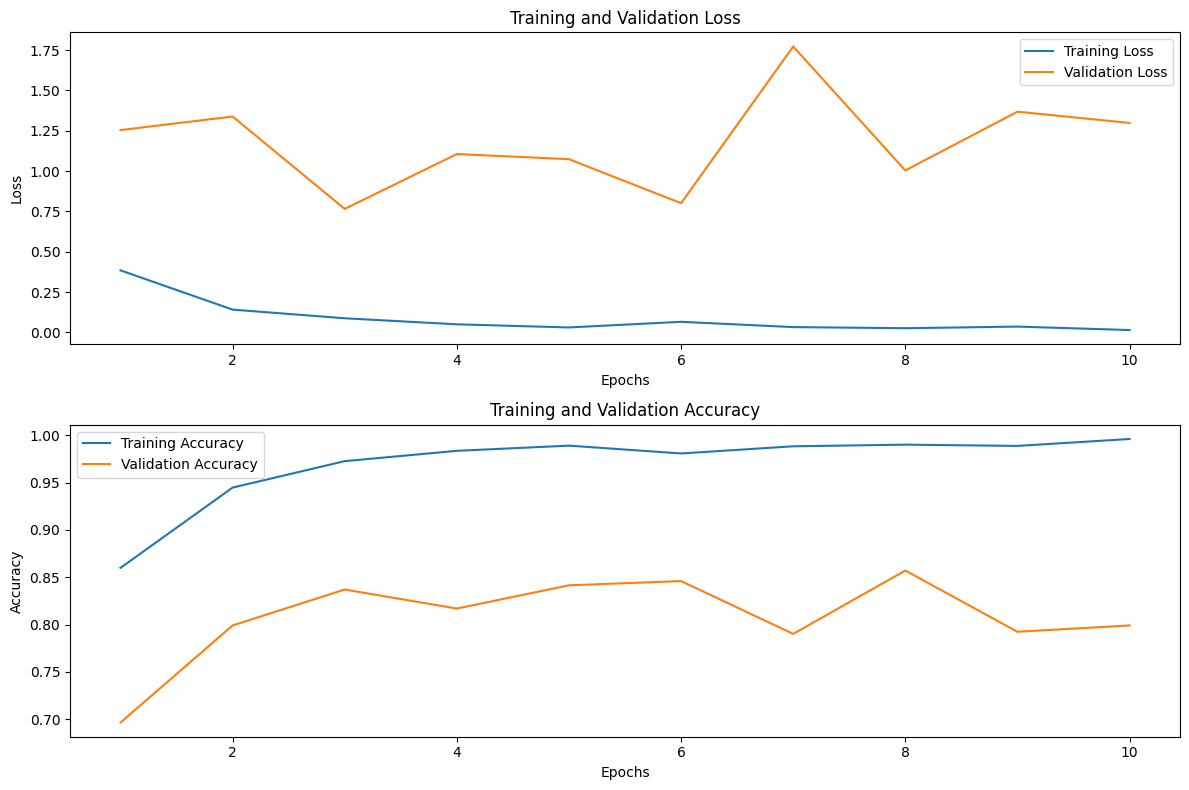

In [ ]:
plot_results(model_3_EF_B0_results)

In [ ]:
from torchvision.models import efficientnet_b1, EfficientNet_B1_Weights

model_4_EF_B1 = pre_trained(EfficientNet_B1_Weights, efficientnet_b1, drop_out = 0.5, in_features = 1280, out_features = len(class_names), device = device)

Downloading: "https://download.pytorch.org/models/efficientnet_b1-c27df63c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-c27df63c.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 81.6MB/s]


In [ ]:
torch.cuda.manual_seed(42)

NUM_EPOCHS = 5



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_4_EF_B1.parameters(),
                             lr = 0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


from timeit import default_timer as timer
start_time = timer()

model_4_EF_B1_results = pipeline(model = model_4_EF_B1,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        scheduler = scheduler,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = timer()

print(f"total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

epoch: 0 | train loss:  0.4290 | train acc:  0.8436 | test loss:  1.4517 | test acc:  0.7277
epoch: 1 | train loss:  0.1152 | train acc:  0.9580 | test loss:  1.2280 | test acc:  0.7178
epoch: 2 | train loss:  0.0615 | train acc:  0.9794 | test loss:  1.1049 | test acc:  0.8170
epoch: 3 | train loss:  0.0362 | train acc:  0.9890 | test loss:  1.1797 | test acc:  0.8214
epoch: 4 | train loss:  0.0384 | train acc:  0.9881 | test loss:  1.6756 | test acc:  0.7902
total training time:  119.810 seconds


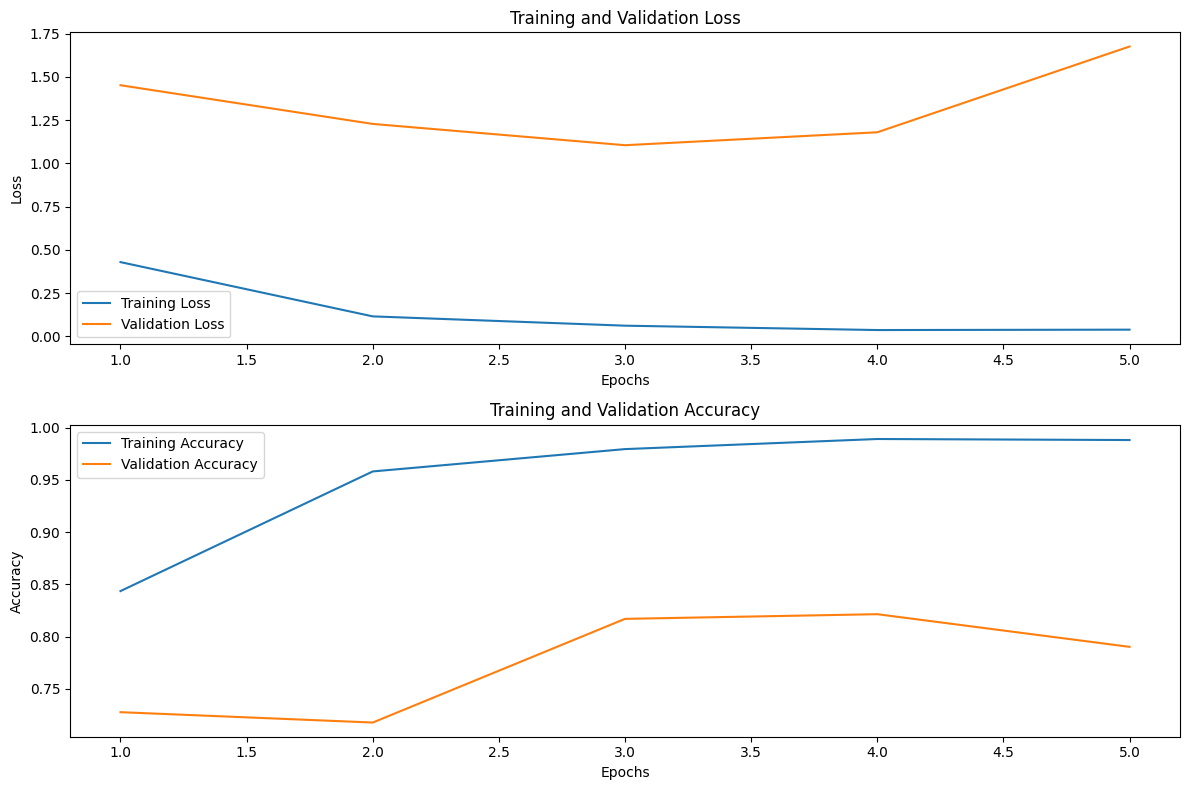

In [ ]:
plot_results(model_4_EF_B1_results)

In [ ]:
model_5_EF_B0 = pre_trained(EfficientNet_B0_Weights, efficientnet_b0, drop_out = 0.4, in_features = 1280, out_features = len(class_names), device = device)

torch.cuda.manual_seed(42)

NUM_EPOCHS = 10



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_5_EF_B0.parameters(),
                             lr = 0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)


from timeit import default_timer as timer
start_time = timer()

model_5_EF_B0_results = pipeline(model = model_5_EF_B0,
                        train_dataloader = train_dataloader,
                        test_dataloader = test_dataloader,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        scheduler = scheduler,
                        epochs = NUM_EPOCHS,
                        device = device)
end_time = timer()

print(f"total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 | train loss:  0.3964 | train acc:  0.8602 | test loss:  1.0744 | test acc:  0.7634
epoch: 1 | train loss:  0.1356 | train acc:  0.9533 | test loss:  0.8083 | test acc:  0.7498
epoch: 2 | train loss:  0.0717 | train acc:  0.9765 | test loss:  1.2032 | test acc:  0.7701
epoch: 3 | train loss:  0.0537 | train acc:  0.9812 | test loss:  1.1736 | test acc:  0.8170
epoch: 4 | train loss:  0.0614 | train acc:  0.9800 | test loss:  0.7076 | test acc:  0.8304
epoch: 5 | train loss:  0.0303 | train acc:  0.9902 | test loss:  1.0730 | test acc:  0.8259
epoch: 6 | train loss:  0.0396 | train acc:  0.9882 | test loss:  0.9822 | test acc:  0.8237
epoch: 7 | train loss:  0.0128 | train acc:  0.9958 | test loss:  1.1916 | test acc:  0.8058
epoch: 8 | train loss:  0.0100 | train acc:  0.9965 | test loss:  1.1842 | test acc:  0.8103
epoch: 9 | train loss:  0.0269 | train acc:  0.9916 | test loss:  1.0699 | test acc:  0.8304
total training time:  209.936 seconds


## Predicting on a custom image

In [ ]:
from typing import Tuple, Dict, List
import torch
import torchvision
import matplotlib.pyplot as plt

def pred_plot(model: torch.nn.Module,
              image_path: str,
              class_names,
              weights_class = None,
              transforms = None,
              device = 'cpu'):

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    target_image = target_image / 255

    if weights_class:
        weights = weights_class.DEFAULT
        auto_transforms = weights.transforms()
        target_image = auto_transforms(target_image)
    elif transforms:
        target_image = transforms(target_image)

    model.to(device)
    model.eval()
    with torch.inference_mode():
        target_image_pred = model(target_image.unsqueeze(dim=0).to(device))

    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    plt.imshow(target_image.squeeze().permute(1, 2, 0).cpu())

    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu().item()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label.cpu().item()} | Prob: {target_image_pred_probs.max().cpu():.3f}"

    plt.title(title)
    plt.axis('off')
    plt.show()


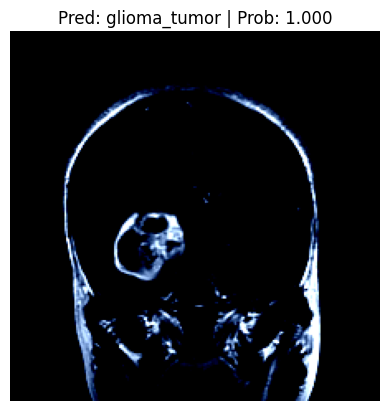

In [ ]:
class_names = train_data.classes

pred_plot(
    model_5_EF_B0,
    "/content/Brain_tumor/Brain_tumor/predict_image/Glioma_pred.jpg",
    class_names=class_names,
    weights_class=EfficientNet_B0_Weights,
    device=device
)
